In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

SEEDS = [40, 41, 43, 44, 45, 46, 47, 48, 49, 50]
TEST_SPLIT_SEED = 40

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [2]:
CSV_PATH = "preprocessed_wildfire_20250816.csv"        # ← 파일명/경로 맞게 수정
TARGET   = "FIRE_SUPESN_HR"   # ← 타깃 컬럼명 맞게 수정

df = pd.read_csv(CSV_PATH)
print("[STEP0] 데이터 로드:", df.shape)
display(df.head(10))

X = df.drop(columns=[TARGET])
y = df[TARGET].values


[STEP0] 데이터 로드: (3560, 19)


,DSPT_REQ_HR,FIRE_SUPESN_HR,CTPV_NM,SGG_NM,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,LFDAU_GRNDS_DSTNC,FCLT_PLC_SCLSF_NM,FND_FIRE_SE_NM,FND_IGTN_PSTN_NM,HR_UNIT_ARTMP,HR_UNIT_WSPD_INFO,WNDRCT_BRNG,HR_UNIT_HUM,golden_time_under_50min,arrival_time_diff,is_night,month_rcpt,dispatch_time_diff
0,246,1200,8,66,11,4,-1.0,1,1,1,-1.0,2.0,7,39.0,1,337.0,1,1,91.0
1,253,600,8,66,4,2,-1.0,0,0,1,5.0,2.0,3,60.0,1,291.0,1,3,38.0
2,643,1457,8,66,9,5,-1.0,1,1,1,7.0,2.0,3,49.0,1,676.0,1,3,33.0
3,578,1529,4,62,5,2,-1.0,1,1,3,0.3,10.5,7,48.0,1,636.0,0,3,58.0
4,874,14464,0,16,26,10,-1.0,2,2,4,-8.7,20.0,8,36.0,1,906.0,1,12,32.0
5,565,19818,10,150,28,8,-1.0,1,1,1,2.3,2.0,7,38.0,1,764.0,0,12,199.0
6,649,6483,0,4,5,7,-1.0,2,2,1,-2.9,20.0,3,36.0,1,690.0,1,12,41.0
7,440,6678,12,47,23,12,16.0,2,2,4,-1.2,2.0,6,89.0,1,446.0,0,1,6.0
8,313,0,7,48,8,1,-1.0,1,1,2,10.2,2.0,8,35.0,1,389.0,0,12,76.0
9,1151,5437,12,219,23,15,-1.0,2,2,1,12.9,2.0,7,26.0,1,1171.0,0,12,20.0



[STEP1] EDA 요약
자료형 요약:
int64      13
float64     6
Name: count, dtype: int64 

기초통계(숫자형):


,count,mean,std,min,25%,50%,75%,max
DSPT_REQ_HR,3560.0,704.108427,640.660144,0.0,361.00,581.0,878.0,16468.0
FIRE_SUPESN_HR,3560.0,6741.344382,11090.968328,0.0,1620.00,3583.5,7163.0,85323.0
CTPV_NM,3560.0,5.764607,5.573609,0.0,1.00,3.0,12.0,16.0
SGG_NM,3560.0,114.305056,67.629008,0.0,52.00,119.0,172.0,221.0
FRSTN_GRNDS_DSTNC,3560.0,16.356742,11.894886,0.0,8.00,14.0,22.0,99.0
CNTR_GRNDS_DSTNC,3560.0,8.669101,7.263789,0.0,3.00,7.0,12.0,74.0
LFDAU_GRNDS_DSTNC,3560.0,1.463202,4.562795,-1.0,-1.00,-1.0,3.0,38.0
FCLT_PLC_SCLSF_NM,3560.0,1.698034,0.605859,0.0,2.00,2.0,2.0,2.0
FND_FIRE_SE_NM,3560.0,1.698034,0.605859,0.0,2.00,2.0,2.0,2.0
FND_IGTN_PSTN_NM,3560.0,1.959831,1.098577,0.0,1.00,1.0,3.0,4.0


결측치 Top10:


DSPT_REQ_HR                0
HR_UNIT_ARTMP              0
month_rcpt                 0
is_night                   0
arrival_time_diff          0
golden_time_under_50min    0
HR_UNIT_HUM                0
WNDRCT_BRNG                0
HR_UNIT_WSPD_INFO          0
FND_IGTN_PSTN_NM           0
dtype: int64


수치형 변수 히스토그램


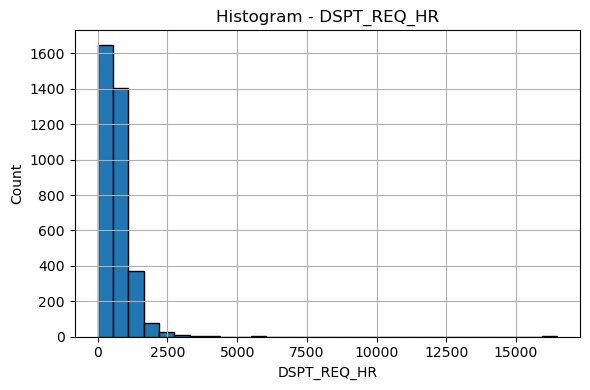

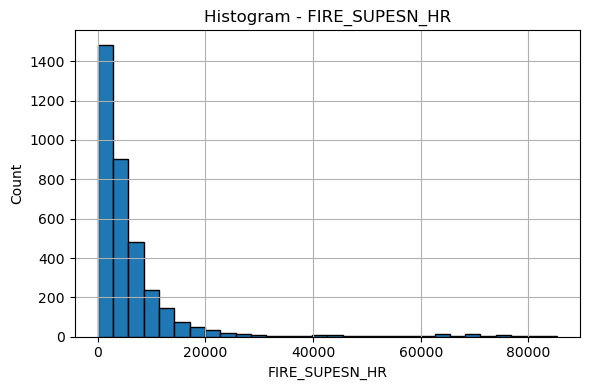

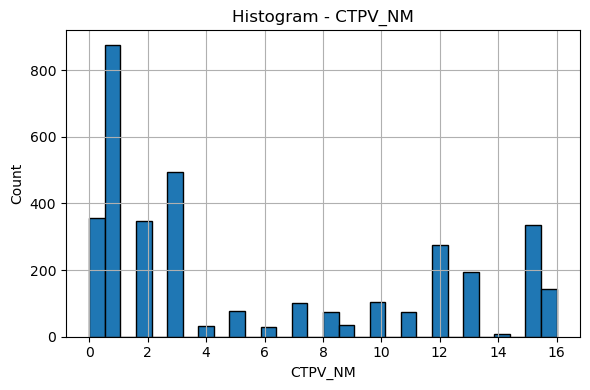

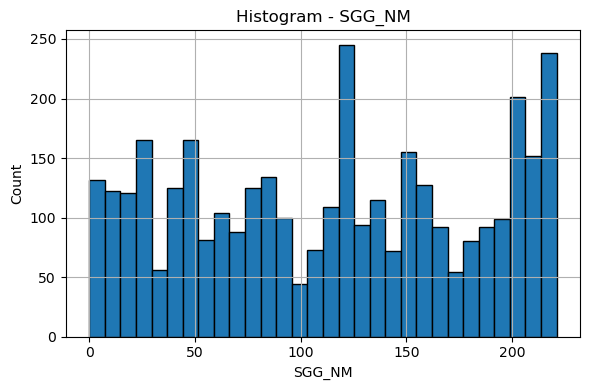

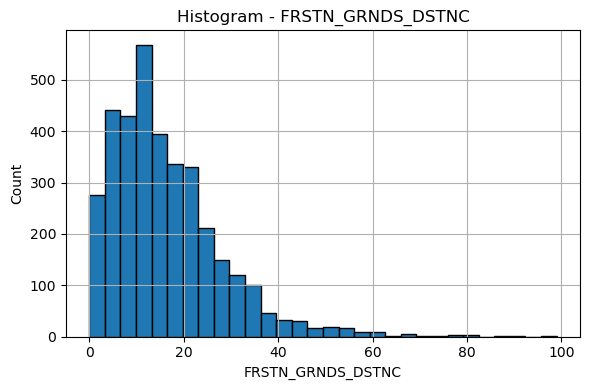

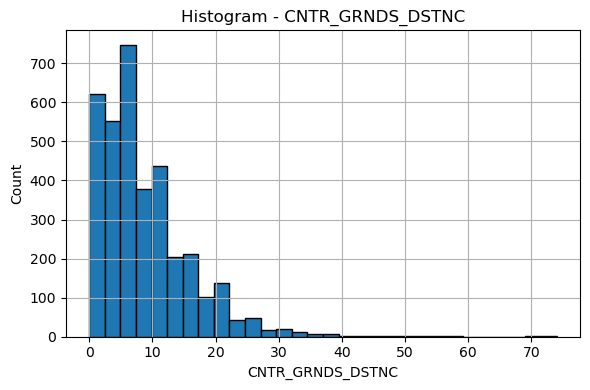

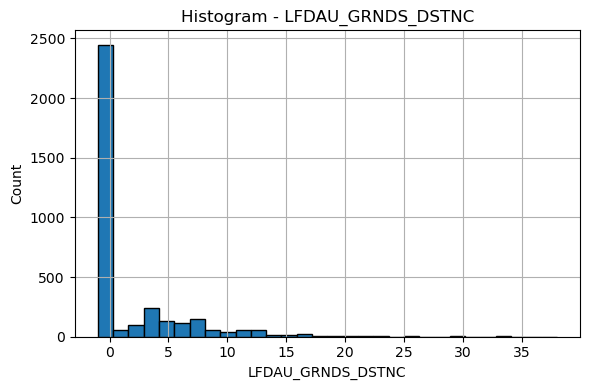

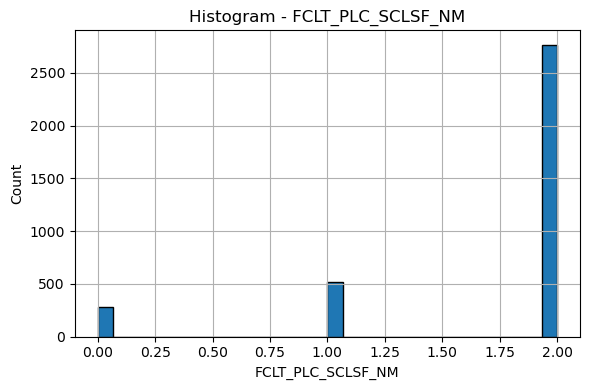

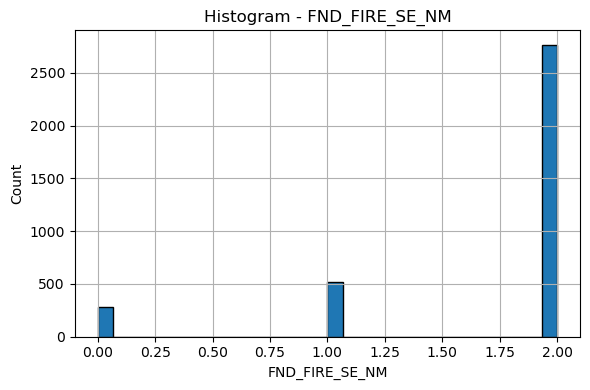

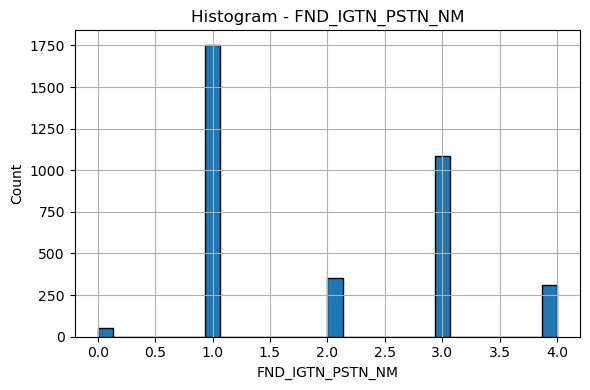

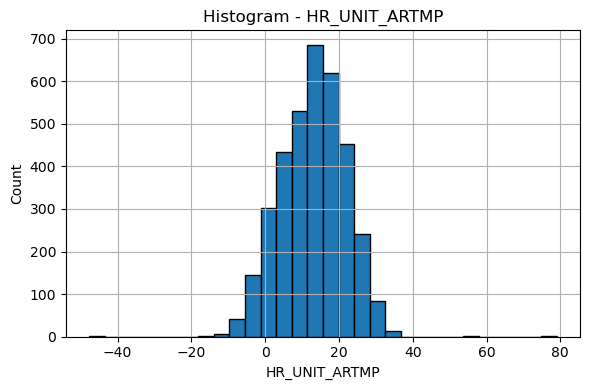

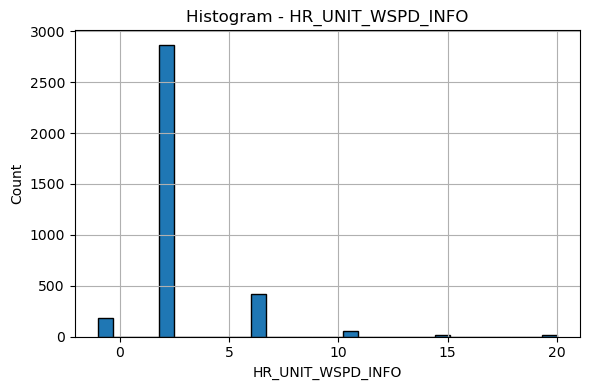

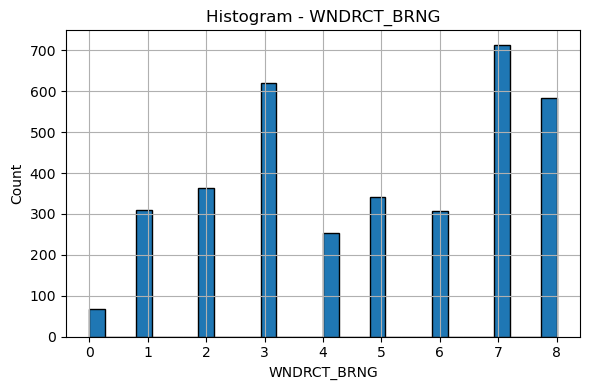

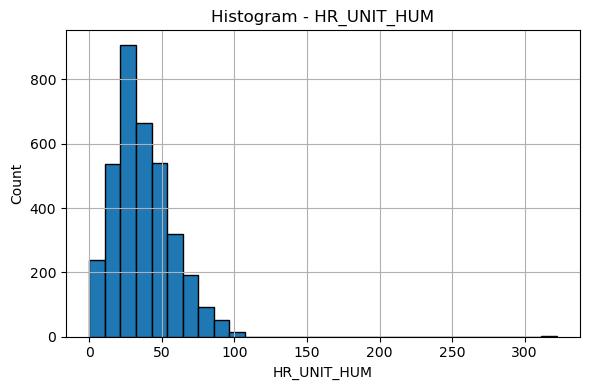

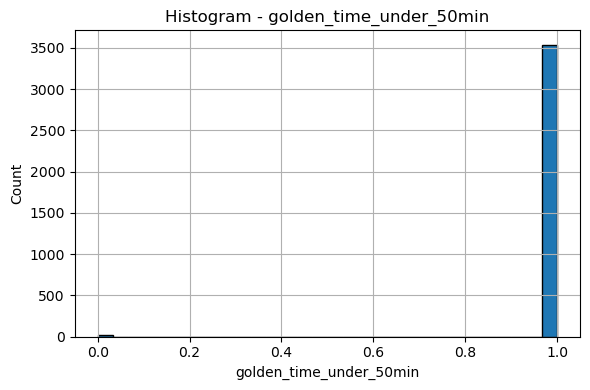

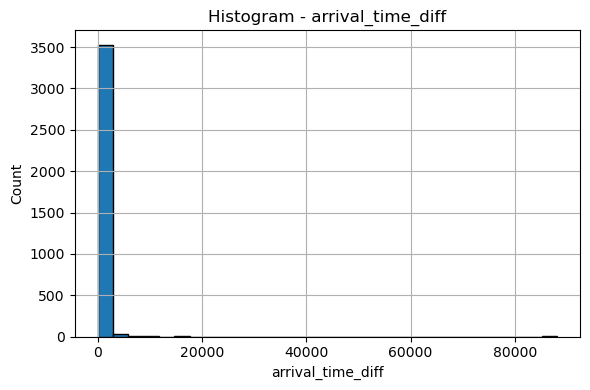

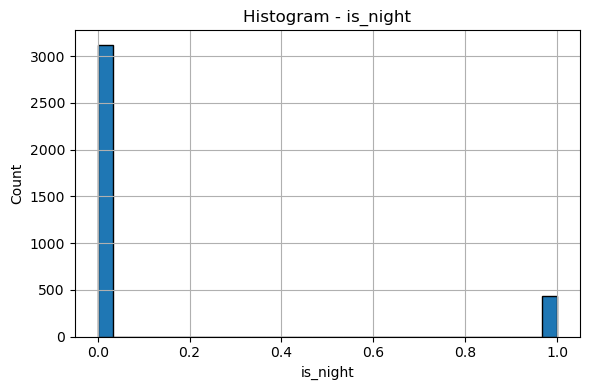

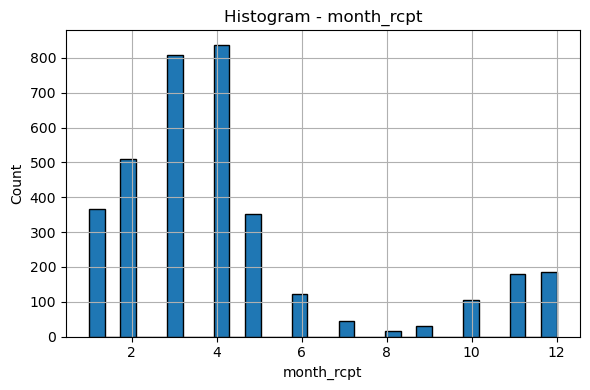

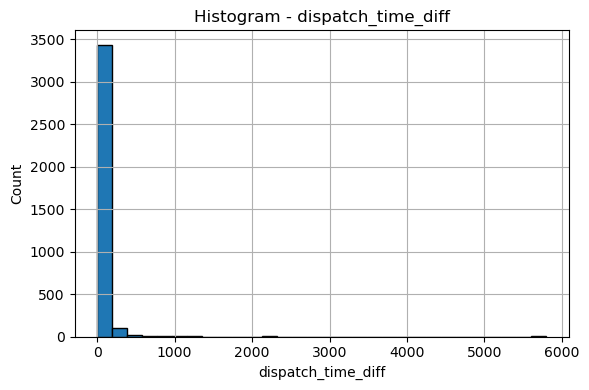

In [10]:
print("\n[STEP1] EDA 요약")
print("자료형 요약:")
print(df.dtypes.value_counts(), "\n")

print("기초통계(숫자형):")
display(df.describe().T)

print("결측치 Top10:")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))

print("\n수치형 변수 히스토그램")

numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30, edgecolor="black")
    plt.title(f"Histogram - {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [4]:
print("\n[STEP2] GridSearchCV (RandomForest, 작은 탐색공간, RMSE 커스텀 스코어)")

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)  # 작을수록 좋음 → 음수로 처리

param_grid = {
    "n_estimators":      [300, 600],
    "max_depth":         [None, 12, 20],
    "min_samples_leaf":  [1, 2, 4],
    "min_samples_split": [2, 4, 8],
    "max_features":      ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1,
    verbose=0
)
grid.fit(X, y)

best_params = grid.best_params_
best_rmse_cv = -grid.best_score_  # 부호 반전

print("Best Params:", best_params)
print(f"Best CV RMSE: {best_rmse_cv:.4f}")



[STEP2] GridSearchCV (RandomForest, 작은 탐색공간, RMSE 커스텀 스코어)
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best CV RMSE: 10798.2704


Exception ignored in: <function ResourceTracker.__del__ at 0x105ad1d00>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107141d00>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10693dd00>
Traceback (most recent call last

In [5]:
print("\n[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정")

# Test 20% 고정
X_rem, X_test, y_rem, y_test = train_test_split(
    X, y, test_size=0.2, random_state=TEST_SPLIT_SEED, shuffle=True
)

records = []

for i, seed in enumerate(SEEDS, start=1):
    # Train:Val = 6:2 (즉, 남은 80%에서 75:25)
    X_train, X_val, y_train, y_val = train_test_split(
        X_rem, y_rem, test_size=0.25, random_state=seed, shuffle=True
    )

    # 5-Fold CV on Train
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    rmse_cv, mae_cv, r2_cv = [], [], []

    for tr_idx, va_idx in kf.split(X_train):
        model_cv = RandomForestRegressor(random_state=seed, n_jobs=-1, **best_params)
        model_cv.fit(X_train.iloc[tr_idx], y_train[tr_idx])
        pred_cv = model_cv.predict(X_train.iloc[va_idx])
        rmse_cv.append(rmse(y_train[va_idx], pred_cv))
        mae_cv.append(mean_absolute_error(y_train[va_idx], pred_cv))
        r2_cv.append(r2_score(y_train[va_idx], pred_cv))

    # 최종 재학습 (Train+Val = 80%) 후, 고정 Test 평가
    X_fit = pd.concat([X_train, X_val], axis=0)
    y_fit = np.concatenate([y_train, y_val], axis=0)

    model = RandomForestRegressor(random_state=seed, n_jobs=-1, **best_params)
    model.fit(X_fit, y_fit)

    pred_test = model.predict(X_test)
    rmse_test = rmse(y_test, pred_test)
    mae_test  = mean_absolute_error(y_test, pred_test)
    r2_test   = r2_score(y_test, pred_test)

    rec = {
        "seed": seed,
        "rmse_cv": np.mean(rmse_cv),
        "mae_cv":  np.mean(mae_cv),
        "r2_cv":   np.mean(r2_cv),
        "rmse_test": rmse_test,
        "mae_test":  mae_test,
        "r2_test":   r2_test
    }
    records.append(rec)
    print(f"Run {i:>2}/10 (seed={seed}) → "
          f"RMSE={rmse_test:.4f}, MAE={mae_test:.4f}, R²={r2_test:.4f}")

df_runs = pd.DataFrame(records)
print("\n개별 결과 미리보기:")
display(df_runs.head())

print("\n=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===")
for m in ["rmse_test", "mae_test", "r2_test"]:
    mean, std = df_runs[m].mean(), df_runs[m].std()
    label = m.replace("_test","").upper()
    print(f"{label:>4} = {mean:.4f} ± {std:.4f}")



[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정
Run  1/10 (seed=40) → RMSE=10051.5662, MAE=5567.2502, R²=0.0404
Run  2/10 (seed=41) → RMSE=10059.3901, MAE=5568.1285, R²=0.0389
Run  3/10 (seed=43) → RMSE=10051.4265, MAE=5566.4607, R²=0.0404
Run  4/10 (seed=44) → RMSE=10027.3965, MAE=5573.7824, R²=0.0450
Run  5/10 (seed=45) → RMSE=10041.6329, MAE=5546.6170, R²=0.0423
Run  6/10 (seed=46) → RMSE=10073.5177, MAE=5577.4768, R²=0.0362
Run  7/10 (seed=47) → RMSE=10056.9336, MAE=5557.8221, R²=0.0394
Run  8/10 (seed=48) → RMSE=10040.7332, MAE=5553.2758, R²=0.0425
Run  9/10 (seed=49) → RMSE=10010.0216, MAE=5544.4072, R²=0.0483
Run 10/10 (seed=50) → RMSE=10043.8839, MAE=5569.0013, R²=0.0419

개별 결과 미리보기:


,seed,rmse_cv,mae_cv,r2_cv,rmse_test,mae_test,r2_test
0,40,10882.190163,5615.416229,0.051793,10051.566176,5567.250177,0.040390
1,41,10436.768826,5482.451303,0.055773,10059.390078,5568.128454,0.038896
2,43,10455.094778,5570.058041,0.065247,10051.426506,5566.460672,0.040417
3,44,11074.335853,5772.904927,0.053747,10027.396521,5573.782382,0.044999
4,45,11192.451264,5788.569657,0.044059,10041.632875,5546.616970,0.042286



=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===
RMSE = 10045.6502 ± 17.6607
 MAE = 5562.4222 ± 11.3055
  R2 = 0.0415 ± 0.0034


In [6]:
print("\n[STEP4] Feature Importance Top 10 (Train+Val로 재학습, seed=42)")

model_imp = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params)
model_imp.fit(X_rem, y_rem)   # 80% (Train+Val)만 사용

importances = model_imp.feature_importances_
idx = np.argsort(importances)[::-1][:10]

fi_table = pd.DataFrame({
    "feature": X.columns[idx],
    "importance": importances[idx]
})
display(fi_table.reset_index(drop=True))



[STEP4] Feature Importance Top 10 (Train+Val로 재학습, seed=42)


,feature,importance
0,DSPT_REQ_HR,0.095242
1,HR_UNIT_ARTMP,0.092101
2,HR_UNIT_HUM,0.090932
3,arrival_time_diff,0.089941
4,dispatch_time_diff,0.087927
5,FRSTN_GRNDS_DSTNC,0.086799
6,CTPV_NM,0.074155
7,CNTR_GRNDS_DSTNC,0.072692
8,SGG_NM,0.071178
9,WNDRCT_BRNG,0.042578


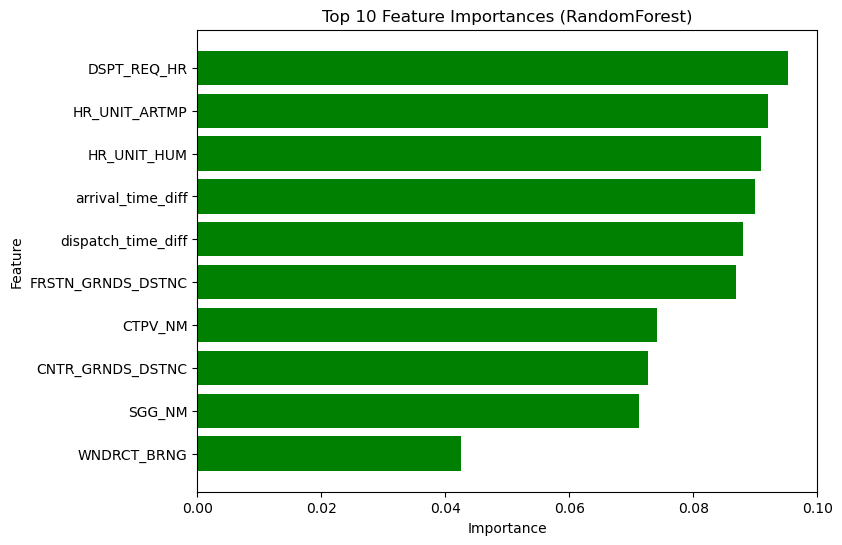

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

# 중요도 상위 10개만 선택
top_n = 10
fi_sorted = fi_table.sort_values("importance", ascending=False).head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(fi_sorted["feature"], fi_sorted["importance"], color="Green")
plt.gca().invert_yaxis()  # 가장 중요한 게 위로 오도록
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (RandomForest)")
plt.show()
#plt.savefig("fi_top10_rf.png", dpi=300, bbox_inches="tight")  # ★ 저장

In [8]:
print("\n[STEP5] SHAP Top 10")

import shap
# 최종 해석은 Train+Val로 학습된 모델 기준
explainer = shap.TreeExplainer(model_imp)

# Test에서 2000행 샘플 (부족하면 전부 사용)
sample_n = min(2000, len(X_test))
X_sample = X_test.sample(sample_n, random_state=42)

shap_values = explainer.shap_values(X_sample)   # (n_sample, n_features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
idx = np.argsort(mean_abs_shap)[::-1][:10]

shap_table = pd.DataFrame({
    "feature": X.columns[idx],
    "mean_|SHAP|": mean_abs_shap[idx]
})
display(shap_table.reset_index(drop=True))



[STEP5] SHAP Top 10


,feature,mean_|SHAP|
0,CTPV_NM,673.051170
1,HR_UNIT_HUM,588.203600
2,FRSTN_GRNDS_DSTNC,566.661317
3,DSPT_REQ_HR,502.748799
4,CNTR_GRNDS_DSTNC,400.613683
5,HR_UNIT_ARTMP,366.734758
6,arrival_time_diff,356.412779
7,LFDAU_GRNDS_DSTNC,350.233886
8,FND_IGTN_PSTN_NM,332.305299
9,is_night,310.735850


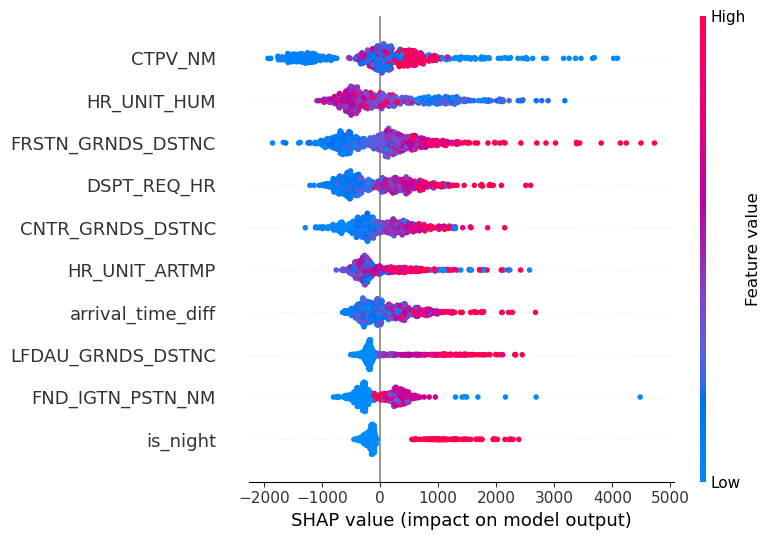

In [9]:
# 빨강(특징값 큼) / 파랑(작음) 색상으로 영향 방향까지 함께 보이는 대표 플롯
shap.summary_plot(
    shap_values,
    X_sample,
    max_display=10,         # 상위 10개
    show=True
)
